In [13]:
# !pip install onnxruntime
# !pip install git+https://github.com/tencent-ailab/IP-Adapter.git
# !pip install -U diffusers transformers accelerate peft

  Using cached peft-0.11.1-py3-none-any.whl.metadata (13 kB)
Using cached peft-0.11.1-py3-none-any.whl (251 kB)


In [1]:
try:
    import lovely_tensors as lt
except:
    ! pip install --upgrade lovely-tensors
    import lovely_tensors as lt
    
lt.monkey_patch()

In [6]:
from diffusers import AutoPipelineForImage2Image, AutoPipelineForText2Image
from diffusers.utils import load_image
import torch
from transformers import CLIPVisionModelWithProjection

image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    "h94/IP-Adapter",
    subfolder="models/image_encoder",
    torch_dtype=torch.float16
)

# pipeline = AutoPipelineForImage2Image.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", image_encoder=image_encoder, torch_dtype=torch.float16).to("cuda")
# pipeline = AutoPipelineForText2Image.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", image_encoder=image_encoder, torch_dtype=torch.float16).to("cuda")
pipeline = AutoPipelineForText2Image.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16).to("cuda")
pipeline.load_ip_adapter("h94/IP-Adapter", subfolder="sdxl_models", weight_name="ip-adapter_sdxl.bin")
# pipeline.load_ip_adapter("h94/IP-Adapter", subfolder="sdxl_models", weight_name="ip-adapter-plus-face_sdxl_vit-h.bin")
pipeline.set_ip_adapter_scale(0.4)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [7]:
# Load the LoRA
pipeline.load_lora_weights('ntc-ai/SDXL-LoRA-slider.pixar-style', weight_name='pixar-style.safetensors', adapter_name="pixar-style")
# Activate the LoRA
pipeline.set_adapters(["pixar-style"], adapter_weights=[3.0])

In [29]:
pipeline.load_lora_weights(
    'jbilcke-hf/sdxl-modern-pixar', 
    weight_name = "pytorch_lora_weights.safetensors",
    adapter_name="modern-pixar"
    # use_auth_token = True 
)

  0%|          | 0/50 [00:00<?, ?it/s]

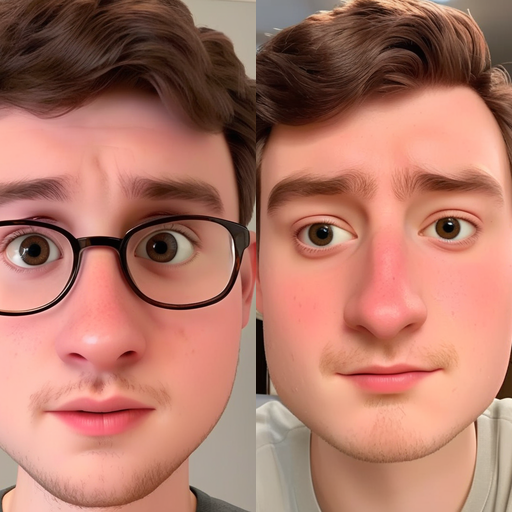

In [41]:
from image_utils import create_collage

image = load_image('assets/o.jpg')
ip_image = load_image('assets/o.jpg')

pipeline.set_ip_adapter_scale(0.5)
pipeline.set_adapters(["pixar-style", "modern-pixar"], adapter_weights=[1.0, 0.7])

negative_prompt = "lowres, text, error, cropped, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, out of frame, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck, username, watermark, signature"

generator = torch.Generator(device="cpu").manual_seed(4)
images = pipeline(
    prompt="cartoon, portrait in modern-pixar style, best quality, high quality, pixar-style",
    negative_prompt=negative_prompt,
    # image=image,
    ip_adapter_image=ip_image,
    generator=generator,
    num_images_per_prompt=2,
    guidance_scale=6
    # strength=0.99,
).images


create_collage(images, (512, 512))

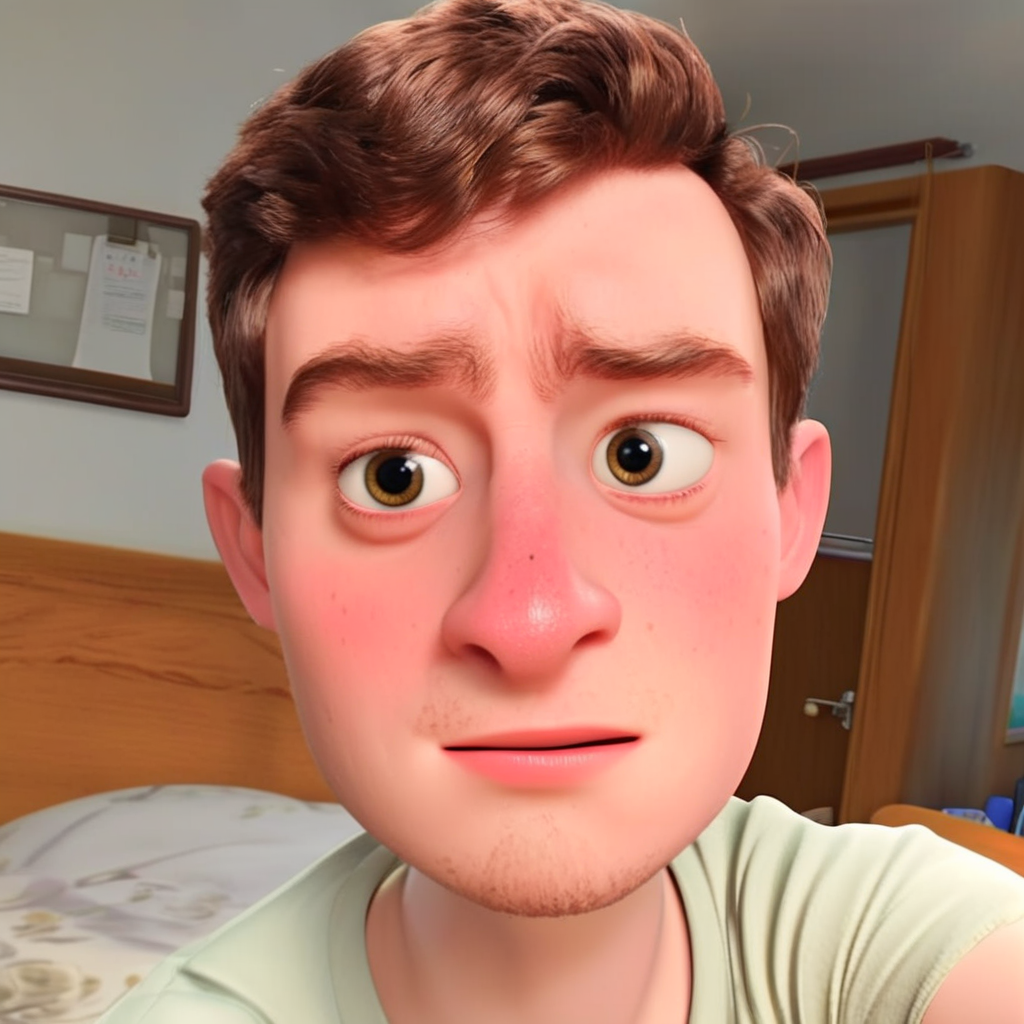

In [35]:
images[1]

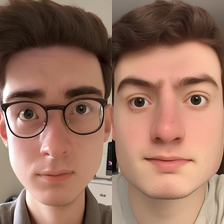

In [15]:
create_collage(images, (224, 224))